## Vervolg

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
from IPython.display import display, HTML
import json
import uuid

### Argument 2: Migratie en leefomstandigheden, landen met de meeste migratie
Zoals eerder beargumenteerd is er sprake van migratie bij historische gebeurtenissen wat de leefomstandigheden van een land omlaag haalt, maar is er ook migratie als het land geen historische gebeurtenis ervaart maar gewoon een gemiddelde slechte leefomstandigheden heeft?
Daarom zal er verder worden gekeken naar het verband van de levensstandaarden en de migratiecijfers van de top 20 landen met de meeste migratie over de tijdsperiode van onze datasets. De 20 landen die we gaan gebruiken voor verder onderzoek zijn hieronder in de figuur aangegeven.

In [2]:
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.


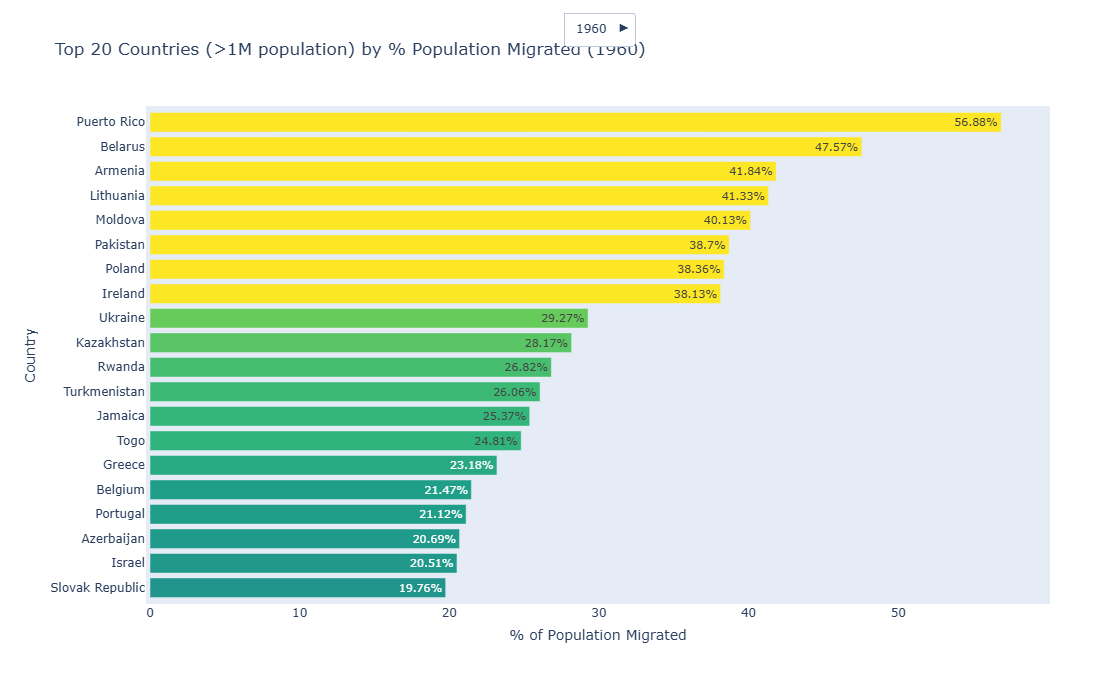

In [3]:


mig = pd.read_excel('P_Data_Extract_From_Global_Bilateral_Migration.xlsx')


pop = pd.read_excel('API_SP.POP.TOTL_DS2_en_excel_v2_124779.xlsx', skiprows=3)


pop.columns = pop.columns.map(str).str.strip()


years = ['1960 [1960]', '1970 [1970]', '1980 [1980]', '1990 [1990]', '2000 [2000]']


for year in years:
    mig[year] = pd.to_numeric(mig[year], errors='coerce')
    year_short = year.split()[0]
    if year_short in pop.columns:
        pop[year_short] = pd.to_numeric(pop[year_short], errors='coerce')


fig = go.Figure()
buttons = []

# Create one bar chart per year
for i, year in enumerate(years):
    year_short = year.split()[0]

    if year_short not in pop.columns:
        print(f"⚠️ Skipping {year_short} — not in population data.")
        continue


    mig_year = mig.groupby('Country Origin Name')[year].sum().reset_index()
    pop_year = pop[['Country Name', year_short]].copy()


    merged = pd.merge(mig_year, pop_year, left_on='Country Origin Name', right_on='Country Name', how='left')
    merged = merged.dropna()
    merged = merged[merged[year] > 0]


    merged = merged[merged[year_short] >= 1_000_000]


    merged['% Migrated'] = (merged[year] / merged[year_short]) * 100


    merged = merged[merged['% Migrated'] <= 100]
    
    # Get top 20 countries by % migrated
    top_20 = merged.nlargest(20, '% Migrated').sort_values('% Migrated', ascending=True)

    fig.add_trace(go.Bar(
        y=top_20['Country Name'],
        x=top_20['% Migrated'],
        orientation='h',
        text=top_20['% Migrated'].round(2).astype(str) + '%',
        textposition='auto',
        hoverinfo='text',
        hovertext=[
            f"<b>{row['Country Name']}</b><br>"
            f"Migrants: {row[year]:,}<br>"
            f"Population: {row[year_short]:,}<br>"
            f"% Migrated: {row['% Migrated']:.2f}%"
            for _, row in top_20.iterrows()
        ],
        visible=(i == 0),
        name=year_short,
        marker=dict(
            color=top_20['% Migrated'],
            colorscale='Viridis',
            cmin=0,
            cmax=merged['% Migrated'].quantile(0.95)
    )))


    visibility = [False] * len(years)
    visibility[i] = True
    buttons.append(dict(label=year_short, method='update',
                        args=[{'visible': visibility},
                              {'title': f'Top 20 Countries (>1M pop) by % Migrated ({year_short})'}]))

# Layout
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='right',
        showactive=True,
        x=0.5,
        y=1.2,
        xanchor='center',
        yanchor='top'
    )],
    title='Top 20 Countries (>1M population) by % Population Migrated (1960)',
    xaxis_title='% of Population Migrated',
    yaxis_title='Country',
    height=700,
    margin=dict(l=150, r=50, b=100, t=100, pad=4),
    showlegend=False
)

fig.show()


> Figuur 3: Een overzicht van de landen met de meeste migratie op basis van hoeveel procent van de bevolking geëmigreerd is.

Deze 20 landen hierboven aangegeven zullen we vergelijken met drie indicatoren die de ontwikkeling/levensstandaarden van een land kunnen schetsen. 

Deze ontwikkeling zijn voornamelijk gefocust op de gezondheid van de burger en zijn als volgt:

 "Survival to age 65, male (% of cohort)",
 "Mortality rate, adult, female (per 1,000 female adults)",
"Life expectancy at birth, total (years)"
Door deze indicatoren in kaart te brengen samen met de migratiecijfers van de landen kunnen we per land een conclusie trekken om vervolgens de eindconclusie over ons perspectief te beantwoorden.


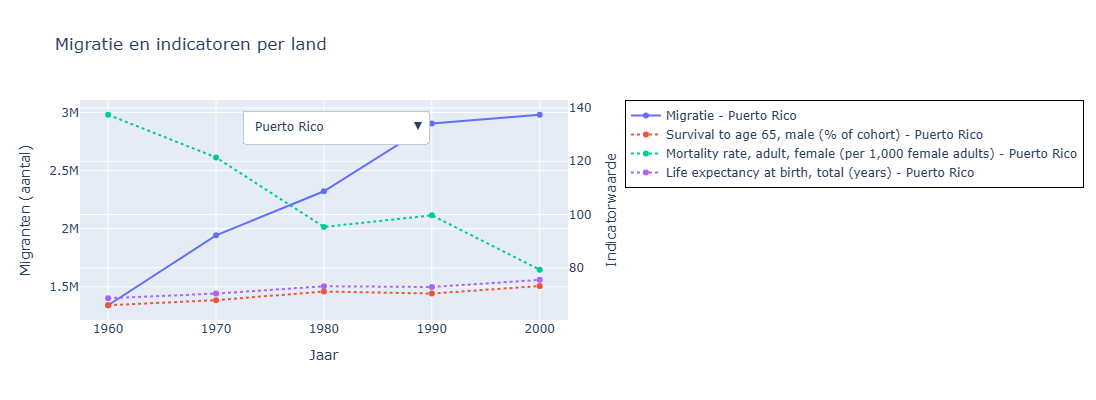

In [4]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

migratie = pd.read_excel("P_Data_Extract_From_Global_Bilateral_Migration.xlsx")
wb_data = pd.read_excel("P_Data_Extract_From_World_Development_Indicators.xlsx")

landen = ["Puerto Rico", "Jamaica", "Albania", "West Bank and Gaza", "Bosnia and Herzegovina", "Ireland", "Georgia", "Armenia", "Trinidad and Tobago", "Moldova", "Kazakhstan", "Jordan", "Azerbaijan", "Kuwait", "Belarus", "Estonia", "Eritrea", "El Salvador", "Lebanon", "Lithuania"]
indicatoren = [
    "Survival to age 65, male (% of cohort)",
    "Mortality rate, adult, female (per 1,000 female adults)",
    "Life expectancy at birth, total (years)"
]

jaar_kolommen = [col for col in migratie.columns if col.startswith('19') or col.startswith('20')]
jaar_kolommen = sorted(jaar_kolommen, key=lambda x: int(x.split()[0]))

fig = make_subplots(specs=[[{"secondary_y": True}]])

traces = []
valid_countries = []

for land in landen:
    migratie_uit_land = migratie[migratie["Country Origin Name"] == land].copy()
    if migratie_uit_land.empty:
        continue
    for col in jaar_kolommen:
        migratie_uit_land[col] = pd.to_numeric(migratie_uit_land[col], errors='coerce')
    totaal_migratie = migratie_uit_land[jaar_kolommen].sum()
    df_migratie = totaal_migratie.reset_index()
    df_migratie.columns = ['Jaar', 'Migranten']
    df_migratie['Jaar'] = df_migratie['Jaar'].str.extract(r'(\d{4})')[0]
    indicator_dfs = []
    for indicator in indicatoren:
        wb_row = wb_data[(wb_data["Country Name"] == land) &
                         (wb_data["Series Name"] == indicator)].copy()
        if wb_row.empty:
            df_empty = pd.DataFrame({'Jaar': df_migratie['Jaar'], indicator: [None]*len(df_migratie)})
            indicator_dfs.append(df_empty)
            continue

        wb_jaar_kolommen = [col for col in wb_row.columns if col.startswith('19') or col.startswith('20')]
        for col in wb_jaar_kolommen:
            wb_row[col] = pd.to_numeric(wb_row[col], errors='coerce')

        df_indicator = wb_row[wb_jaar_kolommen].T.reset_index()
        df_indicator.columns = ['Jaar', indicator]
        df_indicator['Jaar'] = df_indicator['Jaar'].str.extract(r'(\d{4})')[0]
        indicator_dfs.append(df_indicator)


    from functools import reduce
    df_indicator_all = reduce(lambda left,right: pd.merge(left,right,on='Jaar', how='outer'), indicator_dfs)

    merged = pd.merge(df_migratie, df_indicator_all, on='Jaar', how='inner')

    if merged.empty:
        continue

    valid_countries.append(land)

    fig.add_trace(
        go.Scatter(
            x=merged['Jaar'],
            y=merged['Migranten'],
            name=f"Migratie - {land}",
            visible=False,
            hovertemplate="Jaar: %{x}<br>Migranten: %{y:,}",
            line=dict(width=2)
        ),
        secondary_y=False
    )
    traces.append(f"Migratie - {land}")

    for indicator in indicatoren:
        fig.add_trace(
            go.Scatter(
                x=merged['Jaar'],
                y=merged[indicator],
                name=f"{indicator} - {land}",
                visible=False,
                line=dict(dash="dot"),
                hovertemplate=f"Jaar: %{{x}}<br>{indicator}: %{{y:,.2f}}"
            ),
            secondary_y=True
        )
        traces.append(f"{indicator} - {land}")

dropdown_buttons = []

for land in valid_countries:

    visibility = []
    for trace_name in traces:
        if land in trace_name:
            visibility.append(True)
        else:
            visibility.append(False)
    dropdown_buttons.append(
        dict(
            label=land,
            method="update",
            args=[{"visible": visibility},
                  {"title": f"Migratie en indicatoren voor {land}"}]
        )
    )


fig.update_layout(
    title="Migratie en indicatoren per land",
    xaxis_title="Jaar",
    hovermode="x unified",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,
        bordercolor="Black",
        borderwidth=1
    ),
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.5,         
            xanchor="center",  
            y=1,            
            yanchor="top" 
        )
    ],
    height=400,
    width=1100  
)

fig.update_yaxes(title_text="Migranten (aantal)", secondary_y=False)
fig.update_yaxes(title_text="Indicatorwaarde", secondary_y=True)
for i, trace in enumerate(fig.data):
    fig.data[i].visible = "Puerto Rico" in traces[i]



fig.show()


> Figuur 4: Een visualisatie van de top 20 landen met de meeste emigratie tov de bevolking samen met drie indicatoren die de leefomstandigheden samenvatten van een land (Zie legenda voor kleur aanduidingen). Het doel van de visualisatie is om de lezer interactief te tonen dat ieder land niet per se een directe connectie heeft tussen migratie en slechte leefomstandigheden en dus deels het tegendeel wordt bewezen van ons perspectief.

Uit de visualisatie hierboven aangegeven kunnen we een paar conclusies trekken. Allereerst zien we dat slechte levensomstandigheden niet altijd een garantie voor verhoging in migratiecijfers zijn, bij Puerto Rico zien we bijvoorbeeld dat het aantal migranten over de jaren heen wisselt samen met de cijfers van de gekozen indicatoren. Dit geeft wel aan dat er een verband is tussen migratie en de veranderingen in de leefomstandigheden en gezondheid van mensen, maar dat heeft niet altijd een stijging van migratie als gevolg.

Uit sommige specifieke gevallen zoals Mexico eerder gegeven is deze conclusie wel te trekken. Een ander specifiek geval waar deze conclusie is te trekken is Ierland, dit land heeft een massale toename in migratie tussen de jaren 1960-1970. Deze massale toename in migratie is net zoals bij Mexico een historische gebeurtenis verbonden, tijdens deze periode heeft zich “The Troubles” afgespeeld in Noord-Ierland waar conflict en onrust het thema was in deze periode(Gilmartin, 2022). Deze historische evenementen die een slechte leefomstandigheid vormen voor de burger van zowel Mexico als Ierland laat zien dat slechte levensomstandigheden wel degelijk uitmaken voor een toename in migratie wereldwijd maar de visualisatie geeft ook het tegendeel van ons perspectief aan namelijk dat slechte leefomstandigheden niet de centrale reden is voor massale migratie wereldwijd.
